# Trabajo Fin de Máster en Machine Learning y Ciencia de Datos con Python y R

## Predicción de la calidad del crédito

---

**Alumno**: Miguel Corral Martínez

**Tutor**: David Charte Luque

**Máster**: CampusMVP - Machine Learning y Ciencia de Datos con Python y R  

**Fecha**: junio 2024

---

### Resumen

En este Trabajo Fin de Máster se aborda el problema de la predicción de la calidad del crédito, utilizando las técnicas aprendidas de machine learning para analizar y clasificar la fiabilidad de los clientes a la hora de conceder préstamos. Se emplean diferentes modelos de clasificación, incluyendo regresión logística, Random Forest, SVM, k-NN y redes neuronales, para comparar sus rendimientos y seleccionar el más adecuado. Finalmente se utiliza un ensemble para combinar varios modelos buscando mejorar los resultados.


### 1. Carga del conjunto de datos

In [73]:
import pandas as pd

# cargamos el dataset 
df = pd.read_csv('creditg.csv')

# mostramos las primeras 5 filas
df.head()

,ID,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,vty,<0,6,critical/other existing credit,radio/tv,1169,no known savings,>=7,4,male single,...,real estate,67,none,own,2,skilled,1,yes,yes,good
1,dkl,0<=X<200,48,existing paid,radio/tv,5951,<100,1<=X<4,2,female div/dep/mar,...,real estate,22,none,own,1,skilled,1,none,yes,bad
2,bwf,no checking,12,critical/other existing credit,education,2096,<100,4<=X<7,2,male single,...,real estate,49,none,own,1,unskilled resident,2,none,yes,good
3,qln,<0,42,existing paid,furniture/equipment,7882,<100,4<=X<7,2,male single,...,life insurance,45,none,for free,1,skilled,2,none,yes,good
4,uzh,<0,24,delayed previously,new car,4870,<100,1<=X<4,3,male single,...,no known property,53,none,for free,2,skilled,2,none,yes,bad


### 2. Sesión de análisis exploratorio

In [74]:
# resumen estadístico de las variables numéricas
df.describe()

,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.746000,1.407000,1.155000
std,12.058814,2822.736876,1.118715,1.103718,12.367961,0.577654,0.362086
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000
max,72.000000,18424.000000,4.000000,4.000000,149.000000,4.000000,2.000000


In [75]:
# elimino la columna ID porque genera datos y gráficos sin valor ya que es un identificador único, aunque no sé si aquí es el lugar correcto para hacerlo
df = df.drop(columns=['ID'])

# resumen de las variables categóricas
categorical_columns = df.select_dtypes(include=['object']).columns
df[categorical_columns].describe()

,checking_status,credit_history,purpose,savings_status,employment,personal_status,other_parties,property_magnitude,other_payment_plans,housing,job,own_telephone,foreign_worker,class
count,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,990,1000,1000
unique,4,5,10,5,5,4,3,4,3,3,4,2,2,2
top,no checking,existing paid,radio/tv,<100,1<=X<4,male single,none,car,none,own,skilled,none,yes,good
freq,394,530,280,603,339,548,907,332,814,713,630,587,963,700


In [76]:
# información general del dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   checking_status         1000 non-null   object
 1   duration                1000 non-null   int64 
 2   credit_history          1000 non-null   object
 3   purpose                 1000 non-null   object
 4   credit_amount           1000 non-null   int64 
 5   savings_status          1000 non-null   object
 6   employment              1000 non-null   object
 7   installment_commitment  1000 non-null   int64 
 8   personal_status         1000 non-null   object
 9   other_parties           1000 non-null   object
 10  residence_since         1000 non-null   int64 
 11  property_magnitude      1000 non-null   object
 12  age                     1000 non-null   int64 
 13  other_payment_plans     1000 non-null   object
 14  housing                 1000 non-null   object
 15  exist

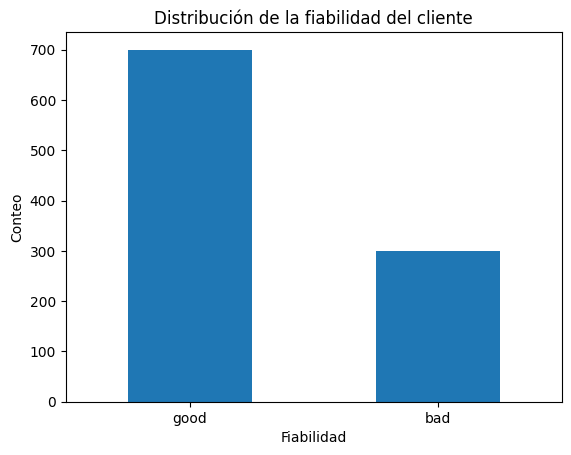

In [77]:
import matplotlib.pyplot as plt

# distribución de la variable objetivo 'class' (good/bad)
df['class'].value_counts().plot(kind='bar')
plt.title('Distribución de la fiabilidad del cliente')
plt.xlabel('Fiabilidad')
plt.ylabel('Conteo')
plt.xticks(rotation=0)
plt.show()

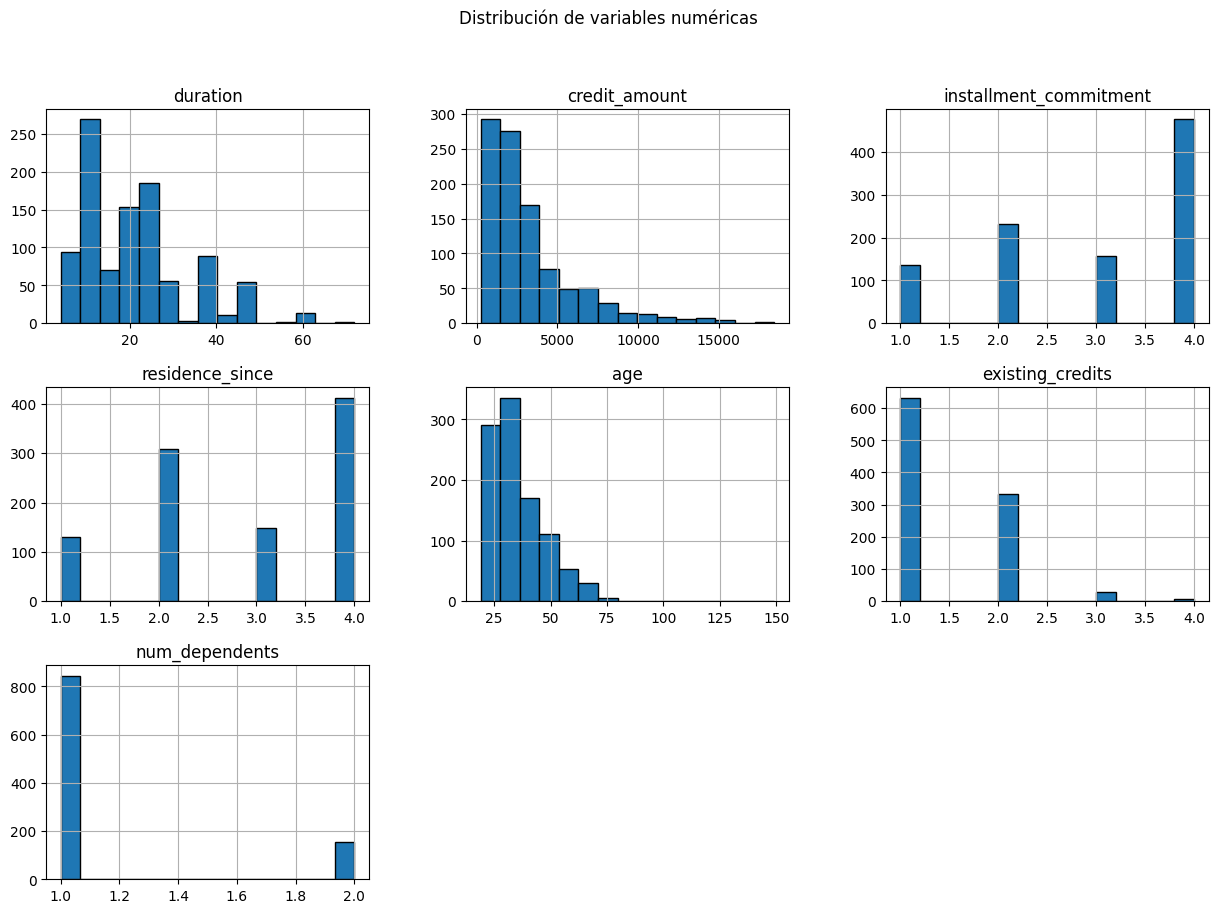

In [78]:
# histograma para las variables numéricas 
num_columns = df.select_dtypes(include=['number']).columns
df[num_columns].hist(figsize=(15, 10), bins=15, edgecolor='black')
plt.suptitle('Distribución de variables numéricas')
plt.show()

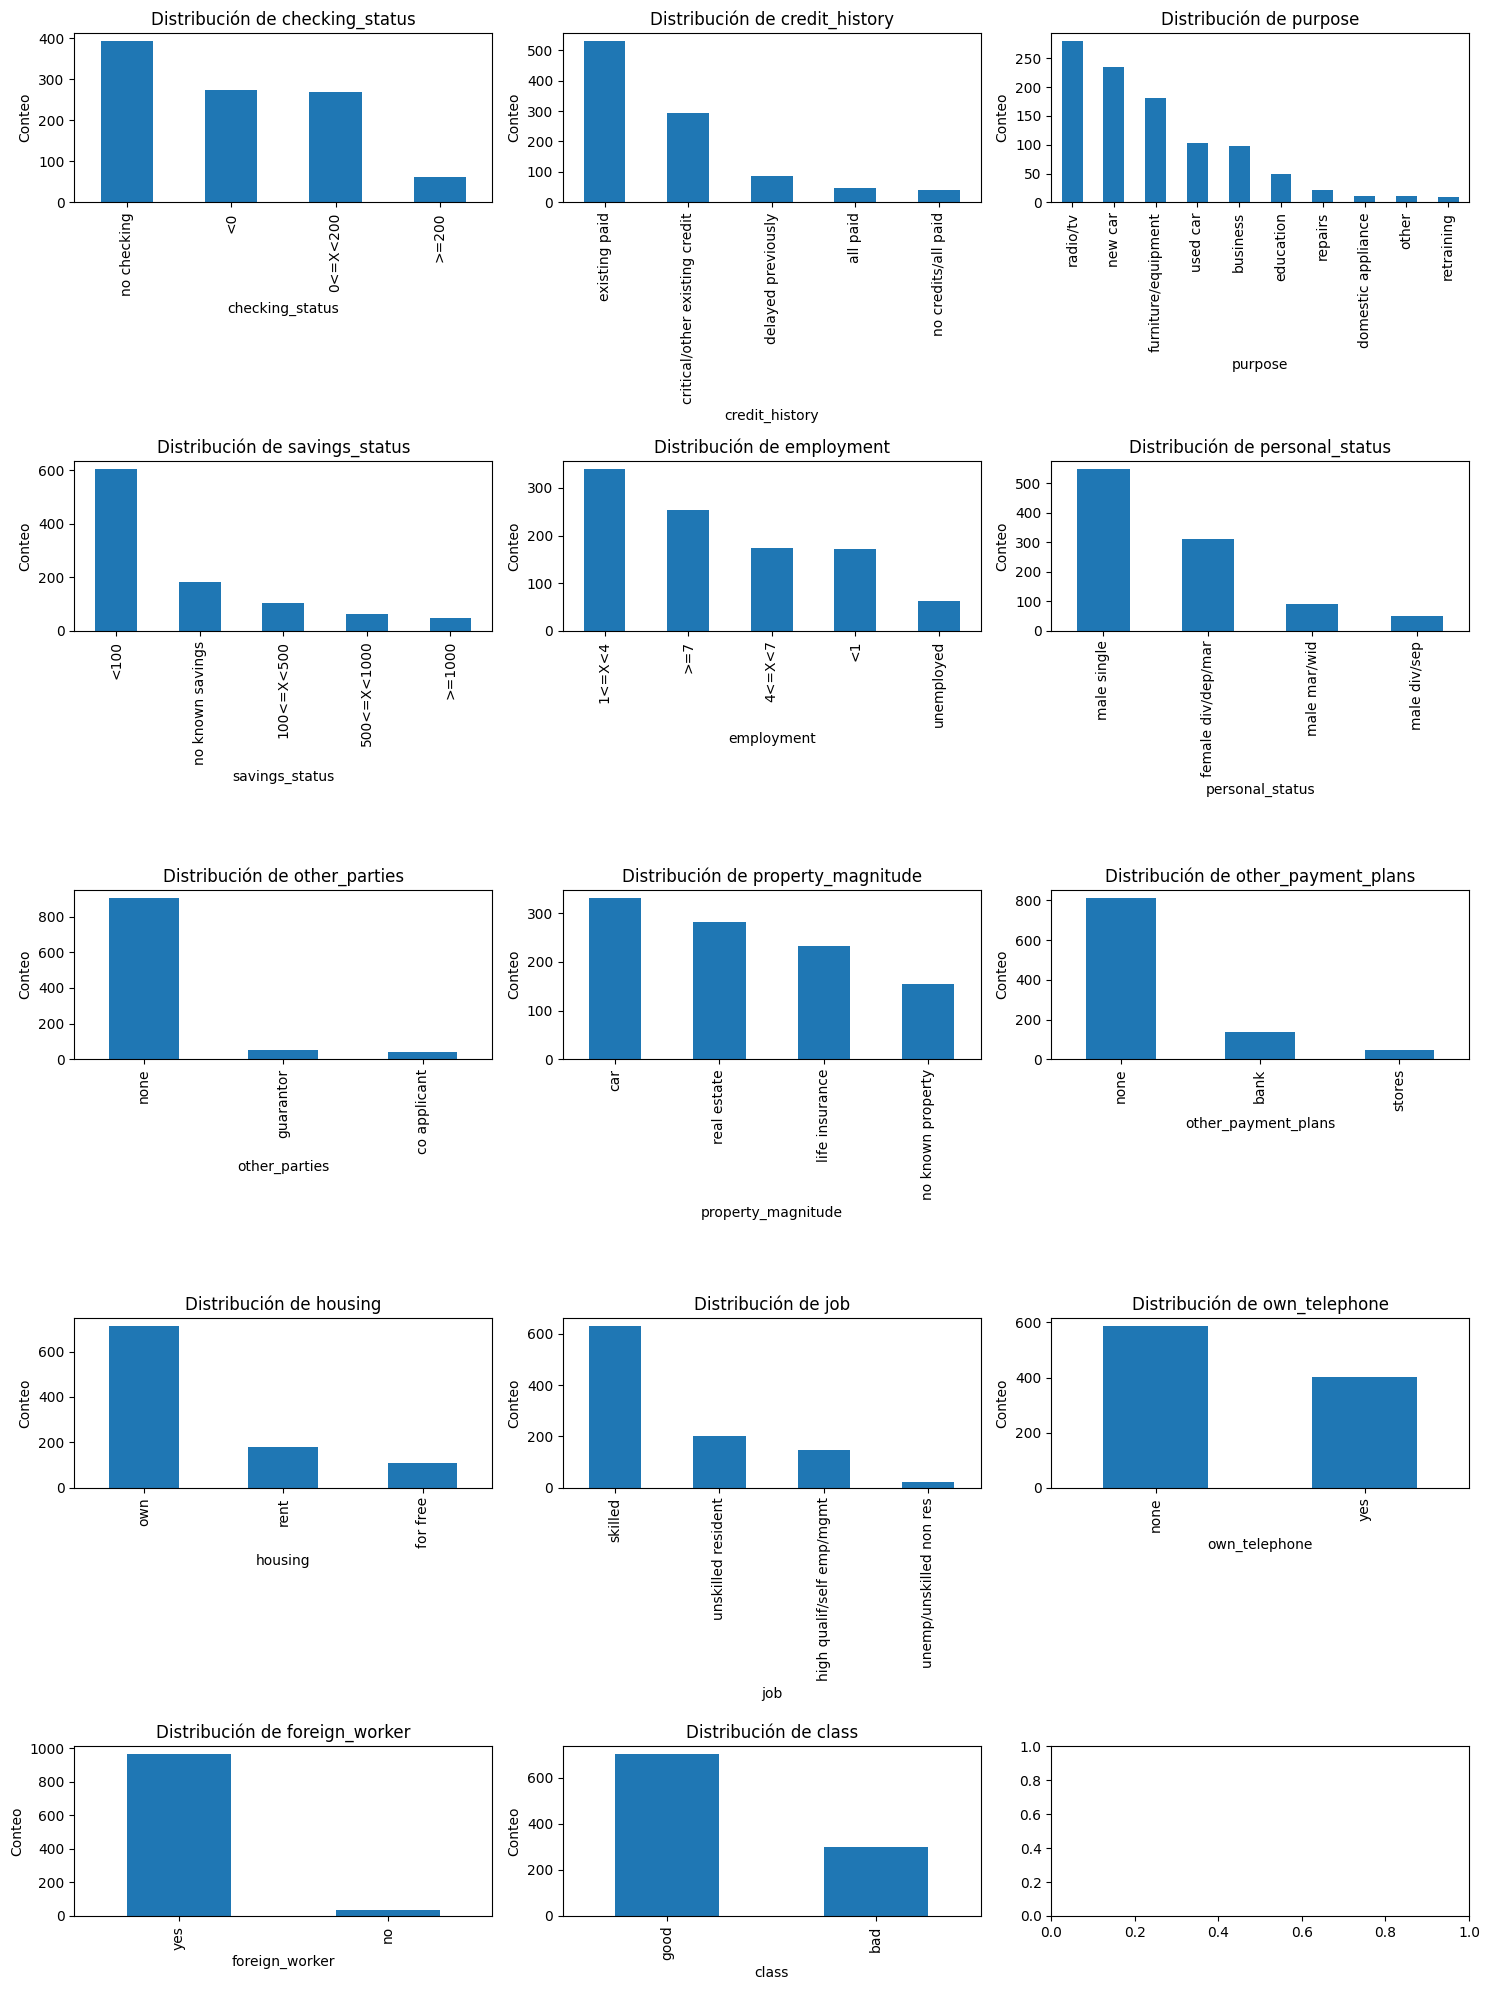

In [79]:
import matplotlib.pyplot as plt
import math

num_cols = 3 
num_rows = math.ceil(len(categorical_columns) / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 5, num_rows * 4))
axes = axes.flatten()  # Convertir la matriz de ejes a una lista plana

# crear gráficos de barras para cada variable categórica
for i, column in enumerate(categorical_columns):
    df[column].value_counts().plot(kind='bar', ax=axes[i])
    axes[i].set_title(f'Distribución de {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Conteo')

plt.tight_layout()
plt.show()


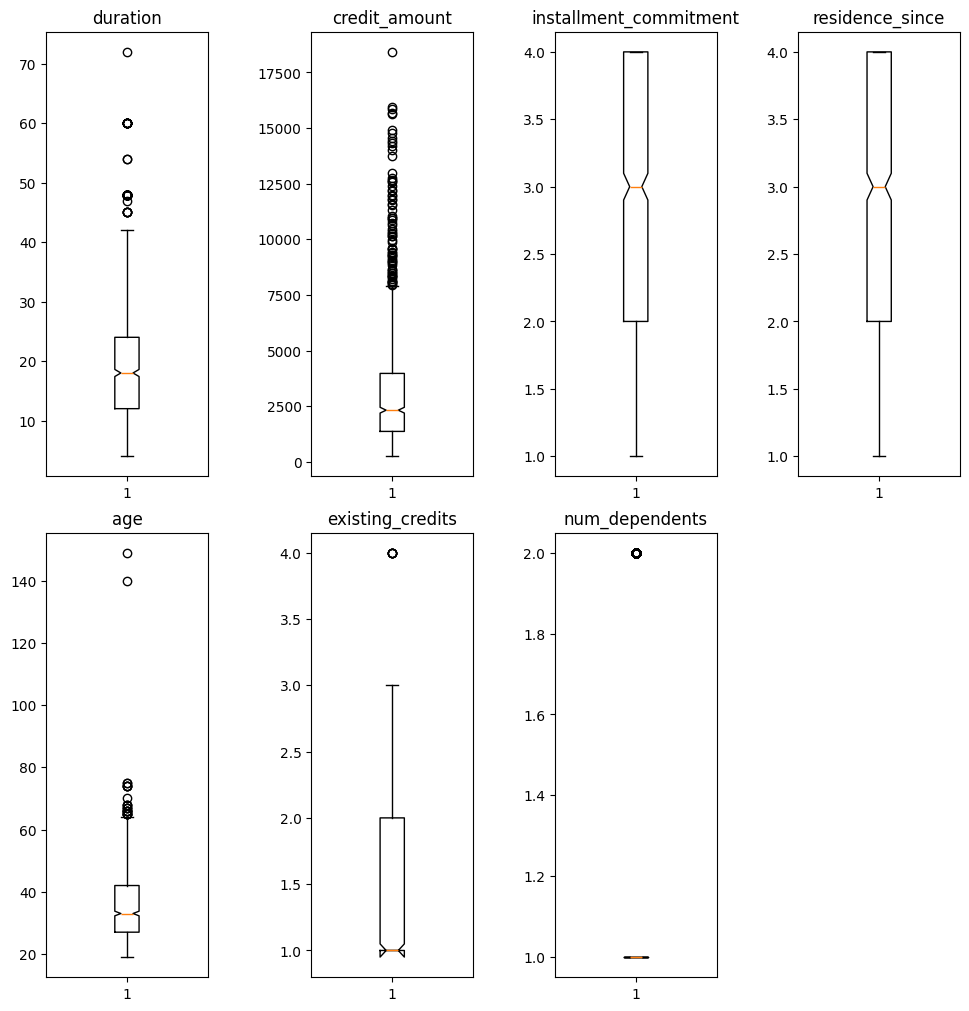

In [80]:
# crear gráficos de cajas y bigotes para las variables numéricas para detectar outliers

num_columns = df.select_dtypes(include=['number']).columns

fig = plt.figure(figsize=(10, 10))
fig.set_constrained_layout(True)           # Modo restringido/manual
fig.set_constrained_layout_pads(w_pad=.25) # Margen lateral

for i, var in enumerate(num_columns):
    ax = fig.add_subplot(2, len(num_columns) // 2 + len(num_columns) % 2, i + 1) 
    ax.set(title=var)
    ax.boxplot(df[var], notch=True)

plt.show()

### 3. Preprocesamiento de los datos

In [81]:
# limpiar edades no válidas (por ejemplo hay una edad de 149 años)
min_age = 18
max_age = 100

df_clean = df[(df['age'] >= min_age) & (df['age'] <= max_age)]

# mostrar estadísticas de la variable 'age' después de limpiar
print(df_clean['age'].describe())

count    998.000000
mean      35.528056
std       11.378009
min       19.000000
25%       27.000000
50%       33.000000
75%       42.000000
max       75.000000
Name: age, dtype: float64


In [82]:
# buscar duplicados y eliminarlos
duplicates = df_clean.duplicated()
print(f"Duplicados encontrados: {duplicates.sum()}")
if duplicates.sum() > 0:
    df_clean = df_clean.drop_duplicates()

Duplicados encontrados: 0


In [83]:
# buscar valores nulos y rellenarlos con la media en columnas numéricas (recibía error: TypeError: can only concatenate str (not "int") to str)
num_cols = df_clean.select_dtypes(include=['number']).columns
nulls = df_clean[num_cols].isnull().sum()
print(f"Valores nulos encontrados en columnas numéricas: {nulls.sum()}")

if nulls.sum() > 0:
    for col in num_cols:
        df_clean.loc[:, col] = df_clean[col].fillna(df_clean[col].mean())

# buscar valores nulos y rellenarlos con la moda en columnas categóricas
cat_cols = df_clean.select_dtypes(include=['object']).columns
nulls_cat = df_clean[cat_cols].isnull().sum()
print(f"Valores nulos encontrados en columnas categóricas: {nulls_cat.sum()}")

if nulls_cat.sum() > 0:
    for col in cat_cols:
        df_clean.loc[:, col] = df_clean[col].fillna(df_clean[col].mode()[0])

# verificar que no hay más valores nulos
nulls_totales = df_clean.isnull().sum().sum()
print(f"Total de valores nulos después de la limpieza: {nulls_totales}")


Valores nulos encontrados en columnas numéricas: 0
Valores nulos encontrados en columnas categóricas: 10
Total de valores nulos después de la limpieza: 0


In [84]:
# guardar el dataframe limpio
df_clean.to_csv('creditg_clean.csv', index=False)

### 4. Entrenamiento del modelo

#### Particionamiento de los datos

In [85]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# carga de datos
df = pd.read_csv('creditg_clean.csv')

# codificar variables categóricas para evitar error "ValueError: could not convert string to float: '0<=X<200'"
df_encoded = df.copy()
for col in df_encoded.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])

# separar datos y clase
data = df_encoded.drop('class', axis=1)
clase = df_encoded['class']

# particionar datos de manera estratificada
data_train, data_test, clase_train, clase_test = train_test_split(data, clase, test_size=0.3, random_state=23, stratify=clase)

standarizer = StandardScaler()
data_train = standarizer.fit_transform(data_train)
data_test = standarizer.transform(data_test)

#### Entrenamiento de modelos

In [86]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

# regresión logística
model_reg = LogisticRegression(class_weight='balanced', random_state=23, max_iter=1000)
model_reg.fit(data_train, clase_train)
clase_pred_reg = model_reg.predict(data_test)

# random forest
model_rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=23)
model_rf.fit(data_train, clase_train)
clase_pred_rf = model_rf.predict(data_test)

# SVM
model_svm = SVC(kernel='linear', class_weight='balanced', random_state=23)
model_svm.fit(data_train, clase_train)
clase_pred_svm = model_svm.predict(data_test)

# k-NN
model_knn = KNeighborsClassifier(n_neighbors=5)
model_knn.fit(data_train, clase_train)
clase_pred_knn = model_knn.predict(data_test)

#### Evaluación de los diferentes modelos

In [87]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

def evaluate_model(name, clase_true, clase_pred):
    print("-------------------------------------------------------")
    print(f"Modelo: {name}")
    print("Exactitud:", accuracy_score(clase_true, clase_pred))
    print("Reporte de clasificación:")
    print(classification_report(clase_true, clase_pred))
    print("-------------------------------------------------------")
    print("\n")

# evaluar todos los modelos
evaluate_model("Regresión", clase_test, clase_pred_reg)
evaluate_model("Random Forest", clase_test, clase_pred_rf)
evaluate_model("SVM", clase_test, clase_pred_svm)
evaluate_model("k-NN", clase_test, clase_pred_knn)

-------------------------------------------------------
Modelo: Regresión
Exactitud: 0.6766666666666666
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.47      0.63      0.54        90
           1       0.82      0.70      0.75       210

    accuracy                           0.68       300
   macro avg       0.64      0.66      0.65       300
weighted avg       0.71      0.68      0.69       300

-------------------------------------------------------


-------------------------------------------------------
Modelo: Random Forest
Exactitud: 0.77
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.71      0.40      0.51        90
           1       0.78      0.93      0.85       210

    accuracy                           0.77       300
   macro avg       0.74      0.66      0.68       300
weighted avg       0.76      0.77      0.75       300

--------------------------------------

           Model  F1-Score
0      Regresión  0.750643
1  Random Forest  0.849673
2            SVM  0.715054
3           k-NN  0.819005


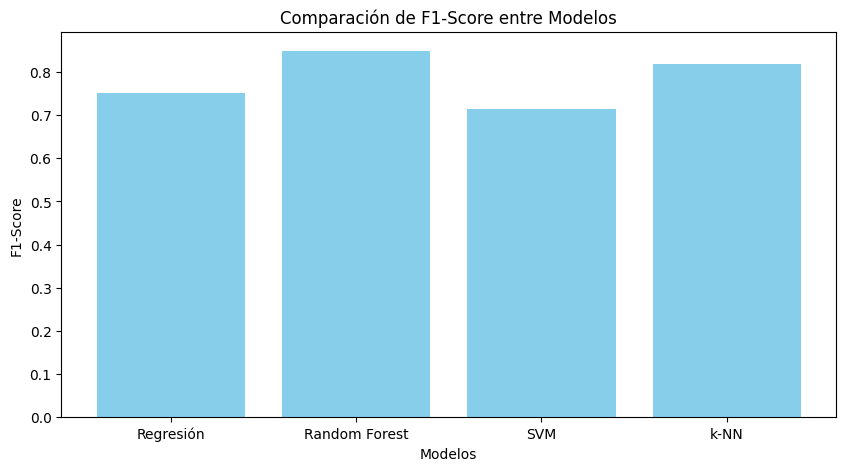

In [88]:
# tabla de comparación de métricas
model_names = ["Regresión", "Random Forest", "SVM", "k-NN"]
f1_scores = [f1_score(clase_test, clase_pred_reg, pos_label=1), 
             f1_score(clase_test, clase_pred_rf, pos_label=1), 
             f1_score(clase_test, clase_pred_svm, pos_label=1), 
             f1_score(clase_test, clase_pred_knn, pos_label=1)]

# crear un DataFrame con los resultados
comparison_df = pd.DataFrame({'Model': model_names, 'F1-Score': f1_scores})
print(comparison_df)

# gráfico de barras de comparación de F1-Score
plt.figure(figsize=(10, 5))
plt.bar(comparison_df['Model'], comparison_df['F1-Score'], color='skyblue')
plt.title('Comparación de F1-Score entre Modelos')
plt.xlabel('Modelos')
plt.ylabel('F1-Score')
plt.show()

#### Ajuste de pesos para evitar falsos positivos

In [89]:
from sklearn.metrics import confusion_matrix

# ajustar pesos para el modelo de regresión
model_reg_adjusted = LogisticRegression(class_weight={0: 2, 1: 1}, random_state=23)
model_reg_adjusted.fit(data_train, clase_train)
clase_pred_reg_adjusted = model_reg_adjusted.predict(data_test)

print("Modelo de regresión (ajustado para minimizar falsos positivos)")
print("Reporte de clasificación:")
print(classification_report(clase_test, clase_pred_reg_adjusted))
print("Matriz de confusión:")
print(confusion_matrix(clase_test, clase_pred_reg_adjusted))

print("\n")
print("------------------------------------------------------")
print("\n")

# comparar con el modelo original
print("Modelo de regresión original")
print("Reporte de clasificación:")
print(classification_report(clase_test, clase_pred_reg))
print("Matriz de confusión:")
print(confusion_matrix(clase_test, clase_pred_reg))

Modelo de regresión (ajustado para minimizar falsos positivos)
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.47      0.57      0.51        90
           1       0.80      0.72      0.76       210

    accuracy                           0.68       300
   macro avg       0.63      0.65      0.64       300
weighted avg       0.70      0.68      0.68       300

Matriz de confusión:
[[ 51  39]
 [ 58 152]]


------------------------------------------------------


Modelo de regresión original
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.47      0.63      0.54        90
           1       0.82      0.70      0.75       210

    accuracy                           0.68       300
   macro avg       0.64      0.66      0.65       300
weighted avg       0.71      0.68      0.69       300

Matriz de confusión:
[[ 57  33]
 [ 64 146]]


#### Entrenamiento ensemble homogéneo con Random Forest

In [90]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# entrenamos el modelo RandomForest
model_rf_ensemble = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=23)
model_rf_ensemble.fit(data_train, clase_train)

# predicciones y evaluación
clase_pred_rf_ensemble = model_rf_ensemble.predict(data_test)
print("Modelo RandomForest (Ensemble Homogéneo)")
print("Exactitud:", accuracy_score(clase_test, clase_pred_rf_ensemble))
print("Reporte de clasificación:")
print(classification_report(clase_test, clase_pred_rf_ensemble))

Modelo RandomForest (Ensemble Homogéneo)
Exactitud: 0.77
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.71      0.40      0.51        90
           1       0.78      0.93      0.85       210

    accuracy                           0.77       300
   macro avg       0.74      0.66      0.68       300
weighted avg       0.76      0.77      0.75       300



#### Entrenamiento modelo kNN

In [91]:
from sklearn.neighbors import KNeighborsClassifier

# entrenamos el modelo kNN ajustando el parámetro k para obtener métricas cercanas al ensemble
model_knn = KNeighborsClassifier(n_neighbors=26)
model_knn.fit(data_train, clase_train)

# predicciones y evaluación
clase_pred_knn = model_knn.predict(data_test)
print("Modelo kNN")
print("Exactitud:", accuracy_score(clase_test, clase_pred_knn))
print("Reporte de clasificación:")
print(classification_report(clase_test, clase_pred_knn))

Modelo kNN
Exactitud: 0.7433333333333333
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.68      0.28      0.39        90
           1       0.75      0.94      0.84       210

    accuracy                           0.74       300
   macro avg       0.71      0.61      0.62       300
weighted avg       0.73      0.74      0.70       300



#### Entrenamiento Red Neuronal

In [92]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam

# crear un modelo secuencial
model_nn = Sequential()

# añadir la capa de entrada
model_nn.add(Input(shape=(data_train.shape[1],)))

# añadir las capas
model_nn.add(Dense(32, activation='relu'))
model_nn.add(Dense(16, activation='relu'))
model_nn.add(Dense(1, activation='sigmoid'))

# compilar el modelo
model_nn.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# entrenar el modelo
model_nn.fit(data_train, clase_train, epochs=100, batch_size=10, verbose=0)

# predicciones y evaluación
clase_pred_nn_prob = model_nn.predict(data_test)
clase_pred_nn = (clase_pred_nn_prob > 0.5).astype(int)

print("Modelo Red Neuronal")
print("Exactitud:", accuracy_score(clase_test, clase_pred_nn))
print("Reporte de clasificación:")
print(classification_report(clase_test, clase_pred_nn))


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Modelo Red Neuronal
Exactitud: 0.7
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.50      0.44      0.47        90
           1       0.77      0.81      0.79       210

    accuracy                           0.70       300
   macro avg       0.64      0.63      0.63       300
weighted avg       0.69      0.70      0.69       300



#### Ensemble final combinando modelos

In [93]:
from sklearn.ensemble import VotingClassifier

# definir los modelos para el ensemble

## no consigo añadir la red neuronal al ensemble, me da error: ValueError: The estimator Sequential should be a classifier
# model_voting = VotingClassifier(estimators=[
#     ('rf', model_rf_ensemble),
#     ('knn', model_knn),
#     ('nn', model_nn)
# ], voting='hard')

## utilizo los otros dos modelos sin la red neuronal
model_voting = VotingClassifier(estimators=[
    ('rf', model_rf_ensemble),
    ('knn', model_knn)
], voting='hard')

# entrenar el ensemble
model_voting.fit(data_train, clase_train)

# predicciones y evaluación del ensemble
clase_pred_ensemble = model_voting.predict(data_test)
# print("Ensemble final (RandomForest + kNN + Red Neuronal)")
print("Ensemble final (RandomForest + kNN)")
print("Exactitud:", accuracy_score(clase_test, clase_pred_ensemble))
print("Reporte de clasificación:")
print(classification_report(clase_test, clase_pred_ensemble))

Ensemble final (RandomForest + kNN)
Exactitud: 0.7666666666666667
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.66      0.47      0.55        90
           1       0.80      0.90      0.84       210

    accuracy                           0.77       300
   macro avg       0.73      0.68      0.69       300
weighted avg       0.75      0.77      0.75       300

